In [48]:
from graphmodels.graphmodel import GraphModel, converte_to_format, concatenate_graph_specs

In [53]:
Waste_nodes = {'PCS': {'type': 'parameter',
                       'name': 'Total Physical Capital Stock',
                       'unit': 'US$'},
               'DCGS': {'type': 'parameter',
                        'name': 'Durable Consumption Good Stock',
                        'unit': 'US$'},
               'RC': {'type': 'parameter',
                      'name': 'Rate of Capital Depreciation',
                      'unit': '%'},
               'PDCG': {'type': 'parameter',
                        'name': 'Proportion of Durable Consumption Goods Discarded per year',
                        'unit': ''},
               'DSES': {'type': 'variable',
                        'name': 'Discarded Socio-Economic Stock',
                        'unit': 'tonnes',
                        'computation': lambda ME1, RC, PCS, PDCG, DCGS, **kwargs: (ME1 * 1e-3) * (RC * PCS + PDCG * DCGS)
                        },
               'RR': {'type': 'input', 'name': 'Recycling Ratio', 'unit': ''},
               'RSES': {'type': 'variable',
                        'name': 'Recycled Socio-Economic Stock',
                        'unit': 'tonnes',
                        'computation': lambda DSES, RR, **kwargs: DSES * RR
                        },
               'Waste': {'type': 'output',
                         'name': 'Total Waste Generated',
                         'unit': 'tonnes',
                         'computation': lambda DSES, RSES, **kwargs: DSES - RSES
                         },
               'ME1': {'type': 'input', 'name': 'Total DMC per GDP', 'unit': 'tonnes/$'}}


VDMC_nodes = {'DE': {'type': 'input',
                     'name': 'Vector of Total Domestic Extraction',
                     'unit': 'tonnes'},
              'I': {'type': 'input', 'name': 'Vector of Total Imports', 'unit': 'tonnes'},
              'E': {'type': 'input', 'name': 'Vector of Total Exports', 'unit': 'tonnes'},
              'VDMC': {'type': 'output',
                       'name': 'Vector of DMC',
                       'unit': 'tonnes',
                       'computation': lambda DE, I, E, **kwargs: DE + I - E
                       }
              }

ME2_nodes = {'MF': {'type': 'variable', 'name': 'Total MF', 'unit': 'tonnes'},
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': ''},
             'ME2': {'type': 'output',
                     'name': 'MF per capita',
                     'unit': 'tonnes/per person',
                     'computation': lambda MF, Pop, **kwargs: MF / Pop
                     }
             }


ME1_nodes = {'DMC': {'type': 'variable', 'name': 'Total DMC', 'unit': 'tonnes'},
             'GDP': {'type': 'parameter', 'name': 'GDP', 'unit': '$'},
             'ME1': {'type': 'output',
                     'name': 'Total DMC per GDP',
                     'unit': 'tonnes/$',
                     'computation': lambda DMC, GDP, **kwargs: DMC / GDP * 1e3
                    }
            }


JE_nodes = {'VDMC': {'type': 'variable', 'name': 'Vector of DMC', 'unit': 'tonnes'},
            'DMC': {'type': 'variable',
                    'name': 'Total DMC',
                    'unit': 'tonnes',
                    'computation': lambda VDMC, **kwargs: VDMC.sum()
                   },
            'MI': {'type': 'input',
                   'name': 'Material Efficiency Improvement',
                   'unit': '%'},
            'RS': {'type': 'variable',
                   'name': 'Resources Saved',
                   'unit': 'tonnes',
                   'computation': lambda MI, DMC, **kwargs: MI * DMC
                  },
            'MS': {'type': 'variable',
                   'name': 'Share of Materials',
                   'unit': '1',
                   'computation': lambda VDMC, DMC, **kwargs: VDMC / DMC
                  },
            'AP': {'type': 'parameter',
                   'name': 'Vector of Lastest Average Prices of Commodities',
                   'unit': '$'},
            'EX': {'type': 'parameter',
                   'name': 'Vector of Export Weights (to Total Commodities)',
                   'unit': ''},
            'CM': {'type': 'variable',
                   'name': 'Cost per unit of Materials',
                   'unit': '$',
                   'computation': lambda AP, EX, **kwargs: AP * EX
                  },
            'PM': {'type': 'variable',
                   'name': 'Total Price per unit of Materials',
                   'unit': '$',
                   'computation': lambda MS, CM, **kwargs: MS * CM
                  },
            'TMS': {'type': 'variable',
                    'name': 'Monetary Savings',
                    'unit': '$',
                    'computation': lambda PM, RS, **kwargs: PM.sum() * RS
                   },
            'AW': {'type': 'parameter', 'name': 'Average Wage', 'unit': '$'
                  },
            'JE': {'type': 'output',
                   'name': 'Job Equivalents',
                   'unit': '1',
                   'computation': lambda TMS, AW, **kwargs: TMS / AW
                  }
           }


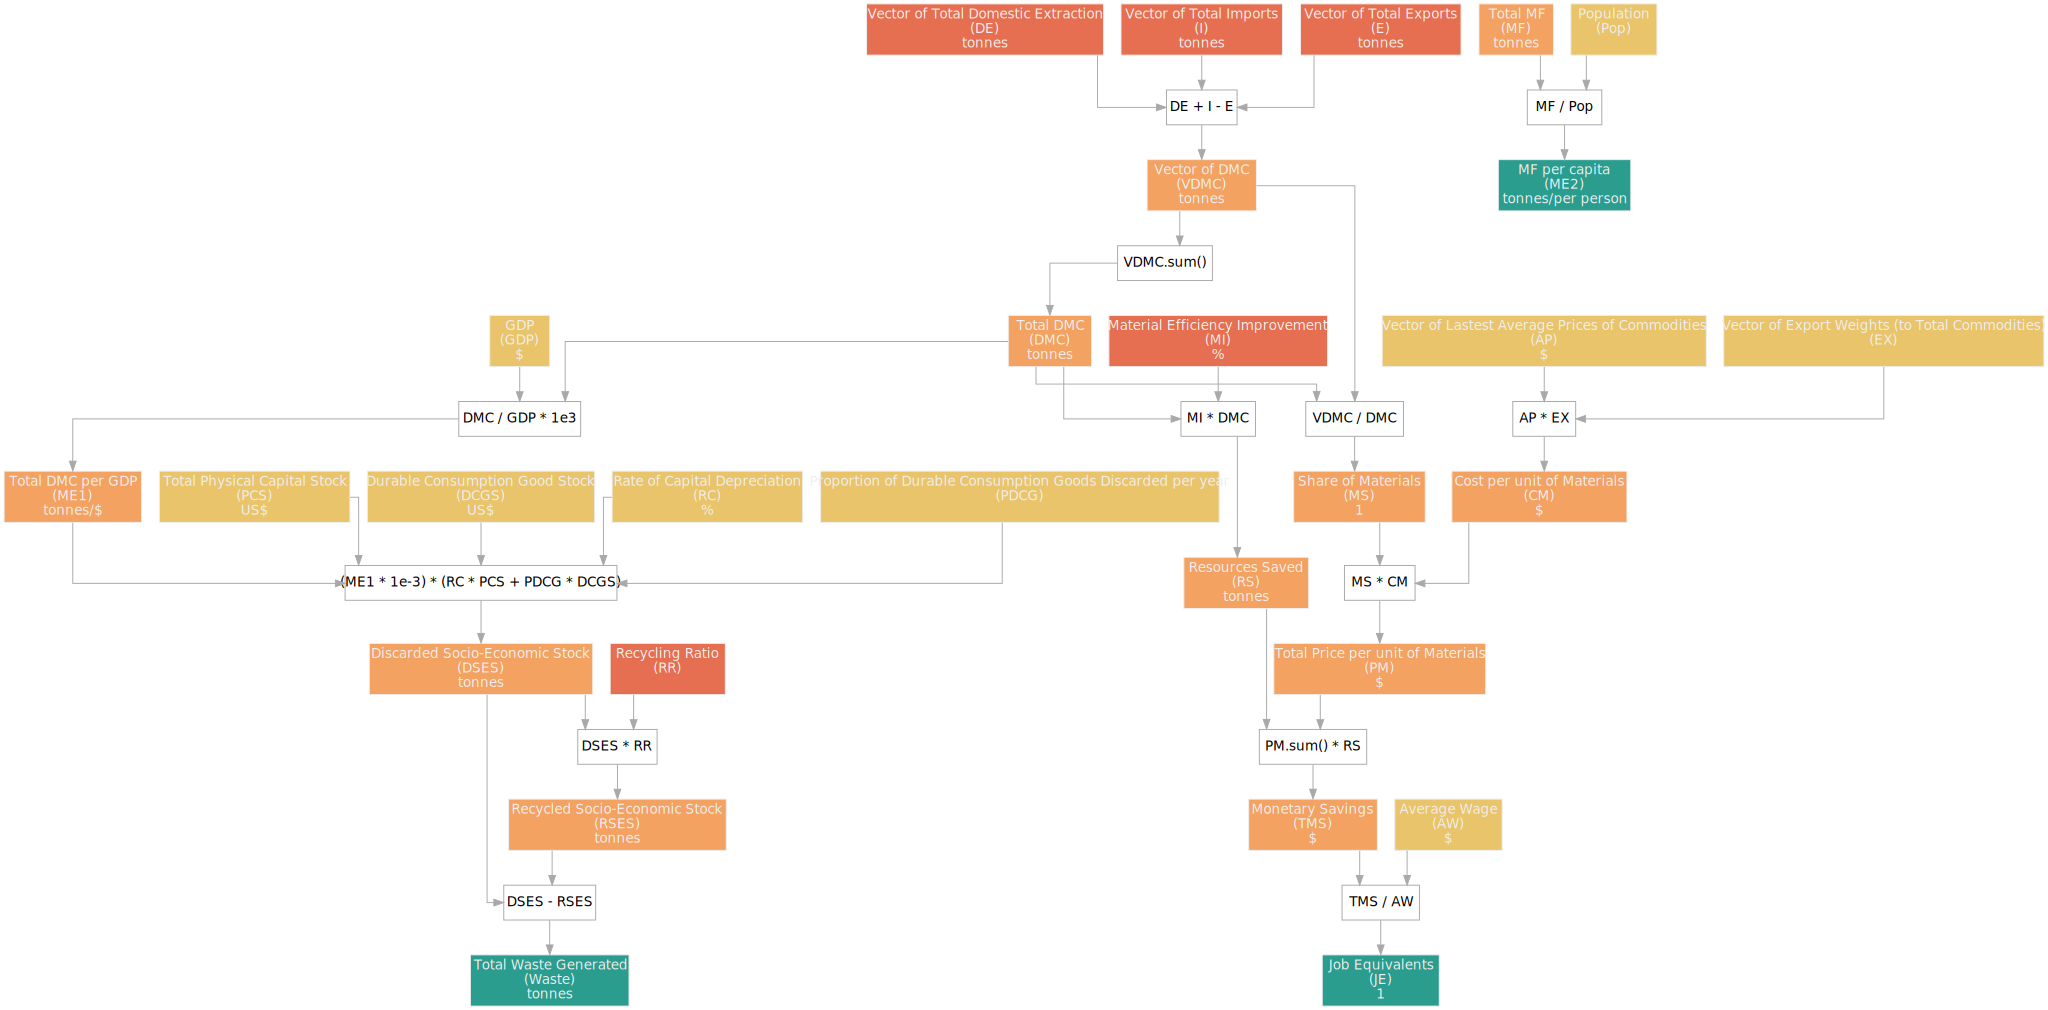

In [54]:
GraphModel(concatenate_graph_specs([Waste_nodes, VDMC_nodes, ME2_nodes, ME1_nodes, JE_nodes])).draw()